<a href="https://colab.research.google.com/github/ksetdekov/trip_choice_optimizer/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from  scipy.stats import gamma, norm

In [2]:
# np.random.seed(43) # фиксируем seed

# risk tolerance
$$\rho = 3.37$$

# initialize

In [3]:
mu_hat_i = 0 # mean
t_i = 0
alpha_i = 0.5
beta_i = 0.5
# rho = 3.37
rho = 1

In [4]:
def update_mean(X, T_last, mu_last):
    mu_new = T_last * mu_last / (T_last + 1) + X / (T_last + 1)
    return mu_new

def update_samples(T):
    return T + 1

def update_shape(a):
    return a + 0.5

def update_rate(X, mu_last, beta_last, T_last):
    beta_new = beta_last + (T_last / (T_last + 1)) * (np.square(X - mu_last)) / 2
    return beta_new

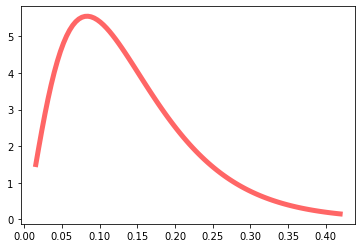

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
a = 2.5
beta = 18
mean, var, skew, kurt = gamma.stats(a, moments='mvsk')
x = np.linspace(gamma.ppf(0.01, a = a, scale =1/beta),
                gamma.ppf(0.99, a = a, scale =1/beta), 100)
ax.plot(x, gamma.pdf(x, a, scale =1/beta),
       'r-', lw=5, alpha=0.6, label='gamma pdf')

In [6]:
hands = pd.DataFrame({'name': ['трамвай + 44', 'пешком + 44', 'мотоцикл', '9 + 44', 'рыжая + жёлтая + салатовая', 
                               'каршеринг', 'серая + салатовая', 'рыжая + фиолетовая + салатовая', 'рыжая + салатовая']})

In [7]:
hands['mu'] = 0
hands['Te'] = 0
hands['alpha'] = 0.5
hands['beta'] = 0.5

hands

,name,mu,Te,alpha,beta
0,трамвай + 44,0,0,0.5,0.5
1,пешком + 44,0,0,0.5,0.5
2,мотоцикл,0,0,0.5,0.5
3,9 + 44,0,0,0.5,0.5
4,рыжая + жёлтая + салатовая,0,0,0.5,0.5
5,каршеринг,0,0,0.5,0.5
6,серая + салатовая,0,0,0.5,0.5
7,рыжая + фиолетовая + салатовая,0,0,0.5,0.5
8,рыжая + салатовая,0,0,0.5,0.5


In [8]:
('трамвай + 44', 35.03)
x_new = 35.03

In [9]:
def to_minutes(timestr: str):
  '''
  convert timestr to float minutes
  '''
  return pd.to_timedelta(timestr).total_seconds()/60

In [10]:
def update_hands(hands, name, value):
    if isinstance(value, str):
        try:
            value = to_minutes(value)
        except ValueError:
            raise ValueError('input time string in hh:mm:ss format')
    elif isinstance(value, float) or isinstance(value, int):
        pass
    else:
        raise ValueError('input time string or int/float value')
    # print(value)
    _, mu, t, alpha, beta = hands[hands.name ==name].values[0]
    beta = update_rate(value, mu, beta, t)
    mu =  update_mean(value, t, mu)
    t = update_samples(t)
    alpha = update_shape(alpha)

    # print(mu, t, alpha, beta)

    hands.loc[hands.name ==name, 'mu'] = mu
    hands.loc[hands.name ==name, 'Te'] = t
    hands.loc[hands.name ==name, 'alpha'] = alpha
    hands.loc[hands.name ==name, 'beta'] = beta

    return hands


In [11]:
pd.to_timedelta("0:25:18").total_seconds()/60

25.3

In [12]:
hands = update_hands(hands, 'трамвай + 44', 35.03)
hands = update_hands(hands, 'пешком + 44', 40)
hands = update_hands(hands, 'пешком + 44', 36.18)
hands = update_hands(hands, 'пешком + 44', 35.13)
hands = update_hands(hands, 'пешком + 44', 31.65)
hands = update_hands(hands, 'трамвай + 44', 51.23)
hands = update_hands(hands, 'мотоцикл', 13)
hands = update_hands(hands, 'трамвай + 44', 29.65)
hands = update_hands(hands, '9 + 44', 37.63)
hands = update_hands(hands, 'трамвай + 44', 39.58)
hands = update_hands(hands, 'рыжая + жёлтая + салатовая', 47.63)
hands = update_hands(hands, 'каршеринг', 31.75)
hands = update_hands(hands, 'рыжая + салатовая', 52.6)
hands = update_hands(hands, 'каршеринг', 23.15)
hands = update_hands(hands, 'рыжая + фиолетовая + салатовая', 52.82)
hands = update_hands(hands, 'серая + салатовая', 52.37)
hands = update_hands(hands, 'мотоцикл', 21.05)
hands = update_hands(hands, 'мотоцикл', 26.40)
hands = update_hands(hands, 'мотоцикл', "0:25:18")

hands

,name,mu,Te,alpha,beta
0,трамвай + 44,38.8725,4,2.5,127.013837
1,пешком + 44,35.7400,4,2.5,18.220700
2,мотоцикл,21.4375,4,2.5,55.943438
3,9 + 44,37.6300,1,1.0,0.500000
4,рыжая + жёлтая + салатовая,47.6300,1,1.0,0.500000
5,каршеринг,27.4500,2,1.5,18.990000
6,серая + салатовая,52.3700,1,1.0,0.500000
7,рыжая + фиолетовая + салатовая,52.8200,1,1.0,0.500000
8,рыжая + салатовая,52.6000,1,1.0,0.500000


: for each t = K + 1, K + 2, . . ., do

7: Sample τi,t from Gamma(αi,t−1, βi,t−1).

8: Sample θi,t from N (ˆµi,t−1, 1/Ti,t−1)

9: Play arm i(t) = arg maxi∈[K] ρθi,t − 1/τi,t and observe reward Xi(t),t

10: Update(ˆµi(t),t−1, Ti(t),t−1, αi(t),t−1, βi(t),t−1)

11: end for


In [21]:
tau = gamma.rvs( a = hands.alpha, scale=1/hands.beta)
theta = norm.rvs(hands.mu, 1/hands.Te)
hands['tau'] = tau
hands['theta'] = theta
hands['SD'] = np.sqrt(1/tau)
hands['var95'] = theta + norm.ppf(1-0.05/2) * hands.SD

hands.reindex(np.argsort(rho * theta + 1/tau))

,name,mu,Te,alpha,beta,tau,theta,SD,var95
2,мотоцикл,21.4375,4,2.5,55.943438,0.061025,21.227297,4.048054,29.161336
3,9 + 44,37.6300,1,1.0,0.500000,1.164669,38.593222,0.926614,40.409352
5,каршеринг,27.4500,2,1.5,18.990000,0.076978,26.898671,3.604275,33.962920
4,рыжая + жёлтая + салатовая,47.6300,1,1.0,0.500000,4.396860,50.115860,0.476901,51.050570
7,рыжая + фиолетовая + салатовая,52.8200,1,1.0,0.500000,2.128112,50.334589,0.685493,51.678130
6,серая + салатовая,52.3700,1,1.0,0.500000,1.165075,50.502293,0.926452,52.318106
1,пешком + 44,35.7400,4,2.5,18.220700,0.058988,35.880681,4.117364,43.950567
8,рыжая + салатовая,52.6000,1,1.0,0.500000,0.961987,52.151673,1.019566,54.149986
0,трамвай + 44,38.8725,4,2.5,127.013837,0.022634,39.234874,6.646898,52.262555


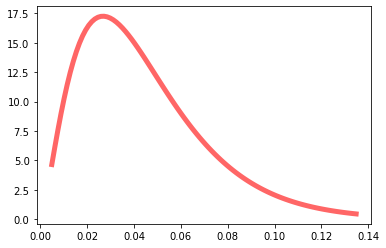

In [14]:
fig, ax = plt.subplots(1, 1)
a = 2.5
beta = 55.94
mean, var, skew, kurt = gamma.stats(a, moments='mvsk')
x = np.linspace(gamma.ppf(0.01, a = a, scale =1/beta),
                gamma.ppf(0.99, a = a, scale =1/beta), 100)
ax.plot(x, gamma.pdf(x, a, scale =1/beta),
       'r-', lw=5, alpha=0.6, label='gamma pdf')